## 6 class AD PD model

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklvq import GMLVQ
from timeit import timeit
from sklearn.model_selection import KFold
from itertools import chain
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
)
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve,roc_auc_score,auc
import colorama
from colorama import Fore, Style
matplotlib.rc("xtick", labelsize="small")
matplotlib.rc("ytick", labelsize="small")

!pip3 install imblearn

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold


In [2]:
def getdata():
    data = pd.read_csv("feature_vectors.csv").to_numpy()
    labels = pd.read_csv("diagnosis_label.csv").to_numpy().squeeze()
    labelscenter = pd.read_csv("center_label.csv").to_numpy().squeeze()

    labelsfinal = labels + labelscenter
    
    # better way to perform this
    labelsdiseases1 = np.where(labelsfinal == 'HCUMCG') 
    centerlabels1 = labelsfinal[labelsdiseases1]
    labelsdiseases2 = np.where(labelsfinal == 'HCUGOSM') 
    #labelsdiseases = np.where(labels == 'HCCUN','1',centerlabels) 
    centerlabels2 = labelsfinal[labelsdiseases2]
    labelsdiseases3 = np.where(labelsfinal == 'HCCUN') 
    centerlabels3 = labelsfinal[labelsdiseases3]
    
    # better way to perform this
    centerlabels = np.concatenate((centerlabels1,centerlabels2,centerlabels3))
    centerdata = data[labelsdiseases1]
    centerdata = np.concatenate((centerdata,data[labelsdiseases2]))
    centerdata = np.concatenate((centerdata,data[labelsdiseases3]))
    
    scalar = StandardScaler()

    return data,labels,centerdata,centerlabels,labelscenter,scalar,labelsfinal

In [3]:
def ztransform(data_ztransform,scalarz):
    # Sklearn's standardscaler to perform z-transform

    # Compute (fit) and apply (transform) z-transform
    # why do we do an inverse z transform
    #scalar = scalar
    data_ztransform = scalarz.fit_transform(data_ztransform)
    return data_ztransform,scalarz

In [4]:
class ProcessLogger:
    def __init__(self):
        self.states = np.array([])

    # A callback function has to accept two arguments, i.e., model and state, where model is the
    # current model, and state contains a number of the optimizers variables.
    def __call__(self, state):
        self.states = np.append(self.states, state)
        return False  # The callback function can also be used to stop training early,
        # if some condition is met by returning True.

        
        
logger = ProcessLogger()



In [5]:
def model_definition_center():
    
    model = GMLVQ(
    distance_type="adaptive-squared-euclidean",
    activation_type="sigmoid",
    activation_params={"beta": 2},
        #wgd
    solver_type="wgd",
    solver_params={"max_runs": 50,"step_size": np.array([0.05, 0.03]),"callback": logger},
    #solver_params={"max_runs": 10,"batch_size":1,"step_size": np.array([0.1, 0.05])},
    random_state=1428,)
    
    return model

In [6]:
def model_definition_disease(correctionmatrix):
    model1 = GMLVQ(
        distance_type="adaptive-squared-euclidean",
        activation_type="sigmoid",
        activation_params={"beta": 2},
        solver_type="wgd",
        solver_params={"max_runs": 50,"step_size": np.array([0.06, 0.03]),"callback": logger},
        #solver_params={"max_runs": 10,"batch_size":1,"step_size": np.array([0.1, 0.05])},
        random_state=1428,
        relevance_correction=correctionmatrix
    )
    return model1

In [7]:
def train_modelkfold(data, label,disease,correctionmatrix1,repeated,scalar,folds):
    modelmatrix = np.zeros((repeated,folds),dtype=object) 
    scalars = np.zeros((repeated,folds),dtype=object)
    datamatrix =  np.zeros((repeated,folds),dtype=object) 
    labelmatrix = np.zeros((repeated,folds),dtype=object)
    accuracies = np.zeros((repeated,folds),dtype=float) 
    # each entry will store the test labels and the predicted labels
    testlabels = np.zeros((repeated,folds),dtype=object) 
    predicted = np.zeros((repeated,folds),dtype=object) 
    probablities = np.zeros((repeated,folds),dtype=object) 
    laeblscore = np.zeros((repeated,folds),dtype=object) 
    testing_indicesM = np.zeros((repeated,folds),dtype=object) 
    traning_indicesM = np.zeros((repeated,folds),dtype=object) 
    
    if disease==False:
        print('Repeated K fold for center data')
    else:
        print('Repeated K fold for disease data')
    for repeated in range(repeated):
        
        print("========Repeated fold number",str(repeated),"========")
        kfold = StratifiedKFold(folds, shuffle=True)
        
        
        for k, (training_indices, testing_indices) in enumerate(kfold.split(data,label)):
            if disease==False:
                model = model_definition_center()
                #print('in this')
                #print(type(model))
            else:
                #model = model_definition_center()
                model = model_definition_disease(correctionmatrix1)
            accuracy = 0
            correct = 0
            trainX, trainY, testX, testY = data[training_indices], label[training_indices], data[testing_indices], label[testing_indices]
            
            
            # oversampling done and z transform applied
            oversample = RandomOverSampler(sampling_strategy='minority')
            trainX, trainY = oversample.fit_resample(trainX, trainY)

            #applying z transform on training data only
            trainX,scalar1 = ztransform(trainX,scalar)
            model.fit(trainX,trainY)
            
            # model is fitted, can also do = model
            modelmatrix[repeated,k] = model
            datamatrix[repeated,k] = trainX
            
            
            labelmatrix[repeated,k] = trainY

            testX = scalar1.transform(testX)
            predictedlabels = model.predict(testX)
            #print(confusion_matrix(testX, predictedlabels))
            for i in range(len(predictedlabels)):                
                if(predictedlabels[i]==testY[i]):
                    correct = correct+1
                    
            scalars[repeated,k] = scalar1
            
            probabilties = model.predict_proba(testX)
            
            laeblscore[repeated,k] = model.decision_function(testX)
            
            probablities[repeated,k] = probabilties
            
            testlabels[repeated,k] = testY
            
            predicted[repeated,k] = predictedlabels
            
            
            testing_indicesM[repeated,k] = testing_indices
            traning_indicesM[repeated,k] = training_indices
            # accuracy and error rate for the validation set(test set in kfold)
            accuracy = correct/len(testY)
            print('%.3f accuracy' % (correct/len(testY)))
            
            # could also plot same for the training set in the kfold
    return modelmatrix,datamatrix,labelmatrix,scalars,testlabels,predicted,probablities,laeblscore,testing_indicesM,traning_indicesM

In [8]:
def calculate_lambda(modelmatrix,repeated):
    #average_lambda = np.mean(sum(model.lambda_ for model in modellist),axis=0)
    #check the shape of total_lambda
    
    total_lambda = np.zeros((36,36),dtype = 'float')
    print(repeated)
    for index in range(repeated):
        print(index)
        lambdaperfold = np.zeros((36,36),dtype='float')        
        
        for modelin in modelmatrix[index,:]:
            lambdaperfold = lambdaperfold + modelin.lambda_

        lambdaperfold = lambdaperfold/np.shape(modelmatrix)[1]
        
        total_lambda = total_lambda + lambdaperfold
        
    total_lambda = total_lambda/repeated

    return total_lambda

In [9]:
def eigendecomposition(average_lambda):
    eigenvalues, eigenvectors = np.linalg.eigh(average_lambda)
    # eigen vectors returned in columns
    # Flip (reverse the order to descending) before assigning.
    eigenvalues = np.flip(eigenvalues)

    # eigenvectors are column matrix in ascending order. Flip the columns and transpose the matrix
    # to get the descending ordered row matrix.
    
    # eigenvectors are row matrices
    #eigenvectors = eigenvectors.T
    #eigenvectors = np.flip(eigenvectors,axis=0)
    eigenvectors = np.flip(eigenvectors, axis=1).T
    
    return eigenvalues,eigenvectors

In [10]:
feature_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','ab','ac','ad','ae','af','ag','ah','ai','aj','ak']


In [11]:

def correction_matrix(eigvectorscenter):
    N=36
    K=1
    I = np.identity(N)
    outerproduct = np.zeros((N,N))   
    for i in range(K):
        # check this
        outerproduct +=  np.outer(eigvectorscenter.T[:,i],eigvectorscenter[i,:])
        outerproduct1 =  np.outer(eigvectorscenter.T[:,0],eigvectorscenter[0,:])
        outerproduct2 =  np.outer(eigvectorscenter.T[:,1],eigvectorscenter[1,:])        
    correctionmatrix = I-outerproduct
    return correctionmatrix

## Center data and labels

In [12]:
data,labels,centerdata1,centerlabels1,labelscenter,scalar,labelsfinal = getdata()



######UMCG indices##########

#ADindices = np.where(labels=='AD')

UMCGindices = np.where(labelscenter=='UMCG')

# fetch umcg indices
datanoUMCG = np.delete(data,UMCGindices,axis=0)


In [13]:
# center 
# UMCG,CUN,UGOSM
labelscenternoUMCG = np.delete(labelscenter,UMCGindices,axis=0)


# get AD indices 

# disease
# remove UMCG
labelsdiseasenoUMCG = np.delete(labels,UMCGindices,axis=0)

### get AD indices
ADindices = np.where(labelsdiseasenoUMCG=='AD')





####################### Remove adindices from center and disease##################################
centerdata_noAD = np.delete(datanoUMCG,ADindices,axis=0)

#Final center labels after AD is removed
centerlabels_noAD = np.delete(labelscenternoUMCG,ADindices,axis=0)


# remove AD
diseasedata_noAD = np.delete(datanoUMCG,ADindices,axis=0)
# labelsnoAD for disease data
diseaselabels_noAD = np.delete(labelsdiseasenoUMCG,ADindices,axis=0)



####################### Remove PD indices from center##################################

PDindices = np.where(diseaselabels_noAD=='PD')

################# FINAL Center data and labels###################

finaldatacenter1 = np.delete(centerdata_noAD,PDindices,axis=0)

finalcenterlabels1 = np.delete(centerlabels_noAD,PDindices,axis = 0)


################# FINAL disease data and labels###################

finaldatadisease = diseasedata_noAD

Finallabelsdisease = diseaselabels_noAD + centerlabels_noAD




In [14]:
print(len(finalcenterlabels1))

63


In [15]:
a2=np.where(Finallabelsdisease=='HCUGOSM')
a3=np.where(Finallabelsdisease=='HCCUN')
Finallabelsdisease[a2] = 'HC'
Finallabelsdisease[a3] = 'HC'

In [16]:
a2

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),)

In [17]:
a3

(array([ 82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100]),)

In [18]:
finaldatadisease[82]

array([ 5.16579464, -5.05629722, -0.21070551, -6.63773558,  3.42607724,
       -4.54324034,  3.19331933, -3.1609173 , -6.68670566,  1.76327137,
        0.67748083,  1.39821179, -0.59816338, -2.76668796,  1.71070952,
        0.70922749,  0.54302644, -4.04797434, -0.10967902,  1.02750101,
       -0.33876431,  1.06058009,  2.11543676, -1.23379108,  0.79207783,
       -2.62350617,  0.83312341, -2.13731982,  0.67345652, -2.32483045,
       -0.11315484, -2.36933238,  2.20936629, -3.21608893, 12.43798366,
       -0.05237054])

In [19]:
-8.26945380e-01

-0.82694538

In [20]:
Finallabelsdisease[100]

'HC'

In [21]:
HCindices =np.append(a2,a3)

In [22]:
HCindices1 = a2+a3

In [23]:
#oversample = RandomOverSampler(sampling_strategy='minority')


In [24]:
def calculate_prototype1(modelmatrix,repeated,dimension,scalarmodel):
    #prototypeaverage = np.zeros((prototype,dimensions),dtype='float')    
    numberofprototypes = len(modelmatrix[0][0].prototypes_)
    prototypeaverage = np.zeros((numberofprototypes,dimension),dtype='float')    
    modellist = list(chain.from_iterable(zip(*modelmatrix)))
    scalarlist = list(chain.from_iterable(zip(*scalarmodel)))
    for modelin in range(len(modellist)):
        for i in range(numberofprototypes):
            #prototypeaverage[i] = np.add(prototypeaverage[i],scalarlist[modelin].inverse_transform(modellist[modelin].prototypes_[i]))
            prototypeaverage[i] = np.add(prototypeaverage[i],scalarlist[modelin].inverse_transform(modellist[modelin].prototypes_[i]))
    return prototypeaverage/len(modellist)

In [25]:
def calculate_prototype(modelmatrix,repeated,dimension,scalarmodel):
    #prototypeaverage = np.zeros((prototype,dimensions),dtype='float')    
    numberofprototypes = len(modelmatrix[0][0].prototypes_)
    prototypeaverage = np.zeros((numberofprototypes,dimension),dtype='float')    
    modellist = list(chain.from_iterable(zip(*modelmatrix)))
    scalarlist = list(chain.from_iterable(zip(*scalarmodel)))
    for modelin in range(len(modellist)):
        for i in range(numberofprototypes):
            #prototypeaverage[i] = np.add(prototypeaverage[i],scalarlist[i].inverse_transform(modellist[modelin].prototypes_[i]))
            prototypeaverage[i] = np.add(prototypeaverage[i],scalarlist[modelin].inverse_transform(modellist[modelin].prototypes_[i]))
    return prototypeaverage/len(modellist)

In [26]:
def diagonal_average_permodel(modelmatrix,dimenison):
    
    # element wise addition by default in numpy
    average = np.zeros(dimension)
    standard_deviation = np.zeros(dimension)
    
    modellist = list(chain.from_iterable(zip(*modelmatrix)))
    for i in range(len(modellist)):
        average = average + np.diagonal(modellist[i].lambda_)
        
        
    
    avarege = average/len(average)
    for i in range(len(modellist)):
        standard_deviation = standard_deviation  + np.square(np.diagonal(modellist[i].lambda_) - average))
    
    standard_deviation = standard_deviation/len(modellist)
    return standard_deviation

In [27]:
repeated = 10
folds = 10
dimension = 36

## center data

In [28]:
centermodel,datamatrix,labelmatrix,scalars1,testlabelsc,predictedc,probabiltiesc,laeblscorec,testing_indicesC,training_indicesC = train_modelkfold(finaldatacenter1,finalcenterlabels1,False,None,repeated,scalar,folds)

average_lambda_center = calculate_lambda(centermodel,repeated)

average_prototype_center = calculate_prototype(centermodel,repeated,36,scalars1)


Std_lambad_center_permodel = diagonal_average_permodel(centermodel,dimension)


print('                                                     ')


print('The sum of the digonal of the center relevance matrix')

print(np.sum(np.diagonal(average_lambda_center)))

print('                                                     ')


eigenvaluescenter,eigenvectorscenter= eigendecomposition(average_lambda_center)


correctionmatrix1 = correction_matrix(eigenvectorscenter)

#correctionmatrix = correction_matrix()


Repeated K fold for center data
========Repeated fold number 0 ========
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
========Repeated fold number 1 ========
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
========Repeated fold number 2 ========
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
========Repeated fold number 3 ========
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
========Repeated fold number 4 ========
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
1.000 accuracy
========Repeated f

## disease data 

In [29]:

diseasemodel,datamatrix1,labelmatrix1,scalars2,testlabelsd,predictedd,probabiltiesd,laeblscored,testing_indicesD,training_indicesD  = train_modelkfold(finaldatadisease,Finallabelsdisease,True,None,repeated,scalar,folds)

average_lambda_disease = calculate_lambda(diseasemodel,repeated)

Std_lambad_disease_permodel = diagonal_average_permodel(diseasemodel,dimension)

eigenvaluesdisease,eigenvectorsdisease = eigendecomposition(average_lambda_disease)

average_prototype_disease = calculate_prototype1(diseasemodel,repeated,36,scalars2)


print('The sum of the digonal of the disease relevance matrix')

print(np.sum(np.diagonal(average_lambda_disease)))


Repeated K fold for disease data
========Repeated fold number 0 ========
0.647 accuracy
0.706 accuracy
0.706 accuracy
0.882 accuracy
0.647 accuracy
0.706 accuracy
0.706 accuracy
0.647 accuracy
0.688 accuracy
0.750 accuracy
========Repeated fold number 1 ========
0.706 accuracy
0.765 accuracy
0.647 accuracy
0.588 accuracy
0.529 accuracy
0.765 accuracy
0.824 accuracy
0.706 accuracy
0.812 accuracy
0.750 accuracy
========Repeated fold number 2 ========
0.706 accuracy
0.765 accuracy
0.765 accuracy
0.706 accuracy
0.824 accuracy
0.529 accuracy
0.706 accuracy
0.765 accuracy
0.750 accuracy
0.688 accuracy
========Repeated fold number 3 ========
0.529 accuracy
0.706 accuracy
0.765 accuracy
0.706 accuracy
0.529 accuracy
0.706 accuracy
0.824 accuracy
0.824 accuracy
0.562 accuracy
0.688 accuracy
========Repeated fold number 4 ========
0.765 accuracy
0.706 accuracy
0.588 accuracy
0.588 accuracy
0.824 accuracy
0.765 accuracy
0.765 accuracy
0.706 accuracy
0.812 accuracy
0.688 accuracy
========Repeated 

## single model center data

In [30]:
# training an individual model
modelc = model_definition_center()
finaldatacenter1,scalarIc = ztransform(finaldatacenter1,scalar)

modelc.fit(finaldatacenter1,finalcenterlabels1)

GMLVQ(activation_params={'beta': 2}, random_state=1428,
      solver_params={'callback': <__main__.ProcessLogger object at 0x7f29a7fd35b0>,
                     'max_runs': 50, 'step_size': array([0.05, 0.03])},
      solver_type='wgd')

## Single model corrected on the average correction matrix

## Oversampled disease data

In [31]:
modeld_oversampled = model_definition_disease(None)

oversample = RandomOverSampler(sampling_strategy='minority')
finaldatadisease_oversampled, Finallabelsdisease_oversampled = oversample.fit_resample(finaldatadisease, Finallabelsdisease)

finaldatadisease_oversampled,scalard__oversampled = ztransform(finaldatadisease_oversampled,scalar)


modeld_oversampled.fit(finaldatadisease_oversampled,Finallabelsdisease_oversampled)
predictedlabels_oversampled = modeld_oversampled.predict(finaldatadisease_oversampled)

## Not oversampled disease data

In [32]:
finaldatadisease,scalarId = ztransform(finaldatadisease,scalar)

modeld = model_definition_disease(correctionmatrix1)

modeld.fit(finaldatadisease,Finallabelsdisease)
predictedlabels = modeld.predict(finaldatadisease)

In [33]:
average_prototype_disease = calculate_prototype1(diseasemodel,repeated,36,scalars2)
average_prototype_center = calculate_prototype(centermodel,repeated,36,scalars1)

## Zero dot product

In [34]:
def check_orthogonality(centermodel,diseasemodel,dimensions,repeated,folds,eigenvectorscenter):
    centerlist = list(chain.from_iterable(zip(*centermodel)))
    disease_center = list()
    disease_averagecenter= list()
    for j in range(2):
        for array,modeld in enumerate(diseasemodel[j]):
            disease_averagecenter.append(np.dot(modeld.eigenvectors_[:2,:],eigenvectorscenter[:2,:].T))
            for modelc in centerlist:
                # eigenvectors are row vectors
                disease_center.append((np.dot(modeld.eigenvectors_[:2,:],modelc.eigenvectors_[:2,:].T)))
    return disease_averagecenter,disease_center

In [35]:
from sklearn.utils.validation import check_is_fitted, check_array
def transform1(X,eigenvaluesaverage,eigenvectoraverage,scale):
    X = check_array(X)
    eigenvaluesaverage[eigenvaluesaverage < 0] = 0
    eigenvectoraverage = np.sqrt(eigenvaluesaverage[:, None]) * eigenvectoraverage
    if scale:
        return np.matmul(X, eigenvectoraverage.T)
    return np.matmul(X, eigenvectoraverage.T)

In [36]:
modeld.classes_

array(['HC', 'PDCUN', 'PDUGOSM'], dtype=object)

## confusion matrix center

In [37]:
def confusionmatrixc(test,predicted):
    
    CUNCUN=CUNUGOSM=UGOSMCUN=UGOSMUGOSM=0
    CUNCUN,CUNUGOSM,UGOSMCUN,UGOSMUGOSM = confusion_matrix(test, predicted, labels= ['CUN', 'UGOSM']).ravel()
            
    return CUNCUN,CUNUGOSM,UGOSMCUN,UGOSMUGOSM
            

In [38]:
def confusionmatrix_61classc(modelmatrix,testlabelmatrix,predictedlabelmatrix):
    #testlist = list(chain.from_iterable(zip(*testlabelmatrix)))
    #predictedlist = list(chain.from_iterable(zip(*predictedlabelmatrix)))
    #1class only passing one set of test and predicted labels
    np.seterr(divide='ignore', invalid='ignore')
    testlist = testlabelmatrix
    predictedlist = predictedlabelmatrix


    #testlist= testlist.astype(int)
    #predictedlist = predictlist.astype(int)
    CUN_tpr = dict()
    CUN_fpr = dict()
    
    UGOSM_tpr = dict()
    UGOSM_fpr = dict()
    
    nCUN_tpr=nCUN_fpr=nUGOSM_tpr=nUGOSM_fpr=0
    
    
    CUNCUN,CUNUGOSM,UGOSMCUN,UGOSMUGOSM  = confusionmatrixc(testlabelmatrix,predictedlabelmatrix)
    
    nCUN_fpr = (UGOSMCUN)/(UGOSMCUN + UGOSMUGOSM)
    nCUN_tpr = (CUNCUN) /(CUNCUN + CUNUGOSM) 
    
    nUGOSM_fpr = (CUNUGOSM)/(CUNUGOSM+CUNCUN)
    nUGOSM_tpr = (UGOSMUGOSM)/(UGOSMUGOSM+UGOSMCUN)
    
    
    #############################
    CUN_fpr = nCUN_fpr
    CUN_tpr =  nCUN_tpr
    
    UGOSM_fpr = nUGOSM_fpr
    UGOSM_tpr = nUGOSM_tpr

#return PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,ADUGOSM_PDCUN ,ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM, ADUMCG_ADUMCG
    return CUN_fpr,CUN_tpr,UGOSM_fpr,UGOSM_tpr

In [39]:
def confusionmatrix_6classc(modelmatrix,testlabelmatrix,predictedlabelmatrix):
    testlist = list(chain.from_iterable(zip(*testlabelmatrix)))
    predictedlist = list(chain.from_iterable(zip(*predictedlabelmatrix)))
    # storing the values 
    np.seterr(divide='ignore', invalid='ignore')


    #testlist= testlist.astype(int)
    #predictedlist = predictlist.astype(int)
    
    CUN_tpr = dict()
    CUN_fpr = dict()
    
    UGOSM_tpr = dict()
    UGOSM_fpr = dict()
    
    for i in range(len(testlist)):
        nCUN_tpr=nCUN_fpr=nUGOSM_tpr=nUGOSM_fpr=0
        
        CUNCUN,CUNUGOSM,UGOSMCUN,UGOSMUGOSM  = confusionmatrixc(testlist[i],predictedlist[i])

        nCUN_fpr = (UGOSMCUN)/(UGOSMCUN + UGOSMUGOSM)
        nCUN_tpr = (CUNCUN) /(CUNCUN + CUNUGOSM) 

        nUGOSM_fpr = (CUNUGOSM)/(CUNUGOSM+CUNCUN)
        nUGOSM_tpr = (UGOSMUGOSM)/(UGOSMUGOSM+UGOSMCUN)
    
        #############################
        CUN_fpr[i] = nCUN_fpr
        CUN_tpr[i] =  nCUN_tpr

        UGOSM_fpr[i] = nUGOSM_fpr
        UGOSM_tpr[i] = nUGOSM_tpr

#return PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,ADUGOSM_PDCUN ,ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM, ADUMCG_ADUMCG
    return CUN_fpr,CUN_tpr,UGOSM_fpr,UGOSM_tpr

In [40]:
testlabelsdsinglec = np.concatenate(list(chain.from_iterable(zip(*testlabelsc))), axis=0 )
predicteddsinglec = np.concatenate( list(chain.from_iterable(zip(*predictedc))), axis=0 )
probabiltysinglec = np.concatenate( list(chain.from_iterable(zip(*probabiltiesc))), axis=0 )

In [41]:
pCUNCUN,pCUNUGOSM,pUGOSMCUN,pUGOSMUGOSM  = confusionmatrixc(testlabelsdsinglec,predicteddsinglec)

In [42]:
cmc = np.array([[pCUNCUN,pCUNUGOSM],
               [pUGOSMCUN,pUGOSMUGOSM]])

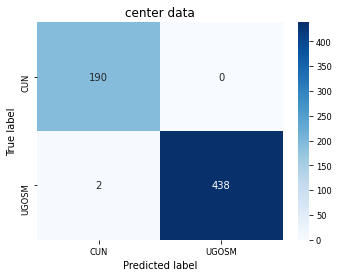

In [43]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

# Transform to df for easier plotting
cm_df = pd.DataFrame(cmc,index = ['CUN', 'UGOSM'], columns = ['CUN', 'UGOSM'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True,cmap='Blues', fmt='g')

plt.title('center data')
plt.ylabel('True label')

plt.xlabel('Predicted label')
plt.show()



In [44]:
CUN_fpr,CUN_tpr,UGOSM_fpr,UGOSM_tpr = confusionmatrix_6classc(centermodel,testlabelsc,predictedc)

CUN_fpr1,CUN_tpr1,UGOSM_fpr1,UGOSM_tpr1 = confusionmatrix_61classc(centermodel,testlabelsdsinglec,predicteddsinglec)

In [45]:
confusionmatrixc(testlabelsdsinglec,predicteddsinglec)

(190, 0, 2, 438)

In [46]:
n_classes=['CUN', 'UGOSM']
plotdict_tpr1c = dict()
plotdict_fpr1c = dict()

plotdict_tpr1c = CUN_tpr1,UGOSM_tpr1
plotdict_fpr1c = CUN_fpr1,UGOSM_fpr1


n_classes=['CUN', 'UGOSM']
plotdictc_tpr = dict()
plotdictc_fpr = dict()

#for j in range(len(repeated)*folds):
for j in range(repeated*folds):

    
    plotdictc_tpr[j]=CUN_tpr[j],UGOSM_tpr[j]
    plotdictc_fpr[j]=CUN_fpr[j],UGOSM_fpr[j]

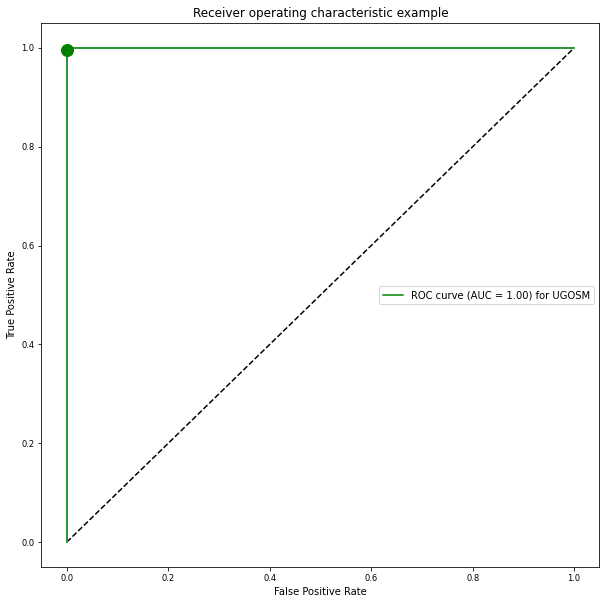

In [47]:
testlist = list(chain.from_iterable(zip(*testlabelsc)))
probabiltylist = list(chain.from_iterable(zip(*probabiltiesc)))
fpru = dict()
tpru = dict()
roc_aucu = dict()
for k in range(len(testlist)):

    n_classes=['CUN', 'UGOSM']

    # structures
    fpr = dict()

    tpr = dict()

    roc_auc = dict()
    
    
    
    fpr1 = dict()

    tpr1 = dict()

    roc_auc1 = dict()
    

    colorrange = ['lightblue','lightblue']
    colorrange2 = ['red','green']
    for i in range(len(n_classes)):
        fpr[i], tpr[i], _ = roc_curve(testlist[k],probabiltylist[k][:,i],pos_label=n_classes[i], drop_intermediate=True)
        roc_auc[i] = auc(fpr[i], tpr[i])
        fpru[k] = fpr
        tpru[k] = tpr
        roc_aucu[k] = roc_auc
        
for j in range(len(n_classes)):
        fpr1[j], tpr1[j], _ = roc_curve(testlabelsdsinglec,probabiltysinglec[:,j],pos_label=n_classes[j], drop_intermediate=True)
        roc_auc1[j] = auc(fpr1[j], tpr1[j])

    
    
    
figsize=(10, 10)
# roc for each class
fig, ax = plt.subplots(figsize=figsize)



ax.plot([0, 1], [0, 1], 'k--')
#ax.set_xlim([0.0, 1.0])
#ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example') 


for k1 in range(len(testlist)):
    for i1 in range(len(n_classes)):  
        ax.plot(fpru[k1][i1], tpru[k1][i1], label='_nolegend_',color=colorrange[i1])

        #ax.plot(PDCUN_fpr[i], PDCUN_fpr[i],  marker="o", markersize="12")
        ax.plot(plotdictc_fpr[k1][i1], plotdictc_tpr[k1][i1],  color=colorrange[i1])#,marker="o", markersize="12")
        
        
#plotdict_tpr1 = ADUGOSM_tpr1,ADUMCG_tpr1,PDCUN_tpr1,PDUGOSM_tpr1,PDUMCG_tpr1
#plotdict_fpr1 = ADUGOSM_fpr1,ADUMCG_fpr1,PDCUN_tpr1,PDUGOSM_fpr1,PDUMCG_fpr1

#for i2 in range(len(n_classes)):
#    ax.plot(fpr1[i2], tpr1[1], label='ROC curve (AUC = %0.2f) for %s' % (roc_auc1[1], n_classes[1]),color=colorrange2[i2])
#    ax.plot(plotdict_fpr1c[1], plotdict_tpr1c[1], color=colorrange2[1],marker="o", markersize="12")

ax.plot(fpr1[1], tpr1[1], label='ROC curve (AUC = %0.2f) for %s' % (roc_auc1[1], n_classes[1]),color=colorrange2[1])
ax.plot(plotdict_fpr1c[1], plotdict_tpr1c[1], color=colorrange2[1],marker="o", markersize="12")

ax.legend(loc="right")   
ax.grid(False)
fig.savefig('roc6class.png')
#ax.grid(alpha=.4)
plt.show()

In [48]:
def confusionmatrix(test,predicted):
    
    HCHC=HCDCUN=HCPDUGOSM=PDCUNHC=PDCUNPDCUN=PDCUNPDUGOSM=PDUGOSMHC=PDUGOSMPDCUN=PDUGOSMPDUGOSM=0
    HCHC,HCDCUN,HCPDUGOSM,PDCUNHC,PDCUNPDCUN,PDCUNPDUGOSM,PDUGOSMHC,PDUGOSMPDCUN,PDUGOSMPDUGOSM = confusion_matrix(test, predicted, labels=['HC','PDCUN', 'PDUGOSM']).ravel()
            
    return HCHC,HCDCUN,HCPDUGOSM,PDCUNHC,PDCUNPDCUN,PDCUNPDUGOSM,PDUGOSMHC,PDUGOSMPDCUN,PDUGOSMPDUGOSM
            

In [49]:
def confusionmatrix_61class(modelmatrix,testlabelmatrix,predictedlabelmatrix):
    #testlist = list(chain.from_iterable(zip(*testlabelmatrix)))
    #predictedlist = list(chain.from_iterable(zip(*predictedlabelmatrix)))
    #1class only passing one set of test and predicted labels
    np.seterr(divide='ignore', invalid='ignore')
    testlist = testlabelmatrix
    predictedlist = predictedlabelmatrix


    #testlist= testlist.astype(int)
    #predictedlist = predictlist.astype(int)
    HC_tpr = dict()
    HC_fpr = dict()
    
    
    PDCUN_tpr = dict()
    PDCUN_fpr = dict()
    
    
    PDUGOSM_tpr = dict()
    PDUGOSM_fpr = dict()
    
    nHC_fpr=nHC_tpr=nPDCUN_fpr=nPDCUN_tpr= nPDUGOSM_fpr= nPDUGOSM_tpr=0
    
    
    HCHC,HCPDCUN,HCPDUGOSM,PDCUNHC,PDCUNPDCUN,PDCUNPDUGOSM,PDUGOSMHC,PDUGOSMPDCUN,PDUGOSMPDUGOSM  = confusionmatrix(testlabelmatrix,predictedlabelmatrix)
    
    nHC_fpr = (PDCUNHC+PDUGOSMHC)/(PDCUNHC+PDUGOSMHC+ PDCUNPDCUN + PDCUNPDUGOSM+  PDUGOSMPDCUN+  PDUGOSMPDUGOSM)
    nHC_tpr = (HCHC) /(HCHC+HCPDCUN+HCPDUGOSM) 
        
    nPDCUN_fpr = (HCPDCUN + PDUGOSMPDCUN)/(HCPDCUN + PDUGOSMPDCUN + HCHC + HCPDUGOSM + PDUGOSMHC +  PDUGOSMPDUGOSM) 
    nPDCUN_tpr = (PDCUNPDCUN)/(PDCUNPDCUN + PDCUNHC + PDCUNPDUGOSM)


    nPDUGOSM_fpr = (HCPDUGOSM + PDCUNPDUGOSM)/(HCPDUGOSM + PDCUNPDUGOSM+HCHC+HCPDCUN +PDCUNPDCUN+ PDCUNHC) 
    nPDUGOSM_tpr = (PDUGOSMPDUGOSM)/(PDUGOSMPDUGOSM+PDUGOSMHC + PDUGOSMPDCUN)

    #############################
    HC_fpr = nHC_fpr
    HC_tpr =  nHC_tpr
    
    PDCUN_fpr = nPDCUN_fpr
    PDCUN_tpr = nPDCUN_tpr
    
    
    PDUGOSM_fpr = nPDUGOSM_fpr
    PDUGOSM_tpr = nPDUGOSM_tpr
    # add to the dictionary
    #pd_fpr[i].append(npd_fpr)
    #pd_tpr[i].append(npd_tpr)
    #ad_fpr[i].append(nad_fpr)
    #ad_tpr[i].append(nad_tpr)

#return PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,ADUGOSM_PDCUN ,ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM, ADUMCG_ADUMCG
    return HC_fpr,HC_tpr,PDCUN_fpr,PDCUN_tpr,PDUGOSM_fpr,PDUGOSM_tpr

In [50]:
def confusionmatrix_6class(modelmatrix,testlabelmatrix,predictedlabelmatrix):
    testlist = list(chain.from_iterable(zip(*testlabelmatrix)))
    predictedlist = list(chain.from_iterable(zip(*predictedlabelmatrix)))
    # storing the values 
    np.seterr(divide='ignore', invalid='ignore')


    #testlist= testlist.astype(int)
    #predictedlist = predictlist.astype(int)
    
    HC_tpr = dict()
    HC_fpr = dict()
    
    PDCUN_tpr = dict()
    PDCUN_fpr = dict()
    
    
    PDUGOSM_tpr = dict()
    PDUGOSM_fpr = dict()
    
    
    for i in range(len(testlist)):
        nHC_fpr=nHC_tpr=nPDCUN_fpr=nPDCUN_tpr= nPDUGOSM_fpr= nPDUGOSM_tpr=0
        HCHC,HCPDCUN,HCPDUGOSM,PDCUNHC,PDCUNPDCUN,PDCUNPDUGOSM,PDUGOSMHC,PDUGOSMPDCUN,PDUGOSMPDUGOSM  = confusionmatrix(testlist[i],predictedlist[i])

        nHC_fpr = (PDCUNHC+PDUGOSMHC)/(PDCUNHC+PDUGOSMHC+ PDCUNPDCUN + PDCUNPDUGOSM+  PDUGOSMPDCUN+  PDUGOSMPDUGOSM)
        nHC_tpr = (HCHC) /(HCHC+HCPDCUN+HCPDUGOSM) 

        nPDCUN_fpr = (HCPDCUN + PDUGOSMPDCUN)/(HCPDCUN + PDUGOSMPDCUN + HCHC + HCPDUGOSM + PDUGOSMHC +  PDUGOSMPDUGOSM) 
        nPDCUN_tpr = (PDCUNPDCUN)/(PDCUNPDCUN + PDCUNHC + PDCUNPDUGOSM)


        nPDUGOSM_fpr = (HCPDUGOSM + PDCUNPDUGOSM)/(HCPDUGOSM + PDCUNPDUGOSM+HCHC+HCPDCUN +PDCUNPDCUN+ PDCUNHC) 
        nPDUGOSM_tpr = (PDUGOSMPDUGOSM)/(PDUGOSMPDUGOSM+PDUGOSMHC + PDUGOSMPDCUN)

        #############################
        HC_fpr[i] = nHC_fpr
        HC_tpr[i] =  nHC_tpr
        
        PDCUN_fpr[i] = nPDCUN_fpr
        PDCUN_tpr[i] = nPDCUN_tpr


        PDUGOSM_fpr[i] = nPDUGOSM_fpr
        PDUGOSM_tpr[i] = nPDUGOSM_tpr

#return PDCUN_PDCUN,PDCUN_PDUGOSM,PDCUN_PDUMCG,PDCUN_ADUGOSM,PDCUN_ADUMCG,PDUGOSM_PDCUN, PDUGOSM_PDUGOSM, PDUGOSM_PDUMCG, PDUGOSM_ADUGOSM, PDUGOSM_ADUMCG,PDUMCG_PDCUN, PDUMCG_PDUGOSM, PDUMCG_PDUMCG, PDUMCG_ADUGOSM, PDUMCG_ADUMCG,ADUGOSM_PDCUN ,ADUGOSM_PDUGOSM ,ADUGOSM_PDUMCG, ADUGOSM_ADUGOSM ,ADUGOSM_ADUMCG,ADUMCG_PDCUN, ADUMCG_PDUGOSM, ADUMCG_PDUMCG, ADUMCG_ADUGOSM, ADUMCG_ADUMCG
    return HC_fpr,HC_tpr,PDCUN_fpr,PDCUN_tpr,PDUGOSM_fpr,PDUGOSM_tpr

## confusion matrix 

In [51]:
testlabelsdsingle = np.concatenate(list(chain.from_iterable(zip(*testlabelsd))), axis=0 )
predicteddsingle = np.concatenate( list(chain.from_iterable(zip(*predictedd))), axis=0 )
probabiltysingle = np.concatenate( list(chain.from_iterable(zip(*probabiltiesd))), axis=0 )

In [52]:
pHCHC,pHCPDCUN,pHCPDUGOSM,pPDCUNHC,pPDCUNPDCUN,pPDCUNPDUGOSM,pPDUGOSMHC,pPDUGOSMPDCUN,pPDUGOSMPDUGOSM  = confusionmatrix(testlabelsdsingle,predicteddsingle)

In [53]:
pHCHC,pHCPDCUN,pHCPDUGOSM,pPDCUNHC,pPDCUNPDCUN,pPDCUNPDUGOSM,pPDUGOSMHC,pPDUGOSMPDCUN,pPDUGOSMPDUGOSM

(408, 58, 164, 36, 611, 23, 143, 45, 192)

In [54]:
cm = np.array([[pHCHC,pHCPDCUN,pHCPDUGOSM],
               [pPDCUNHC,pPDCUNPDCUN,pPDCUNPDUGOSM],
            [pPDUGOSMHC,pPDUGOSMPDCUN,pPDUGOSMPDUGOSM]])

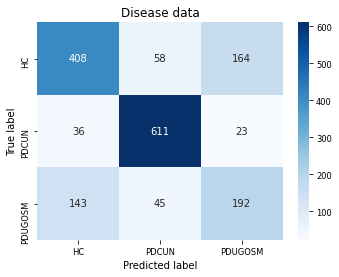

<Figure size 432x288 with 0 Axes>

In [55]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,index = ['HC','PDCUN', 'PDUGOSM'], columns = ['HC','PDCUN', 'PDUGOSM'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True,cmap='Blues', fmt='g')

plt.title('Disease data')
plt.ylabel('True label')

plt.xlabel('Predicted label')
plt.show()
plt.savefig('temp.png')



## confusion matrix for kfold models

In [56]:
HC_fpr, HC_tpr, PDCUN_fpr, PDCUN_tpr, PDUGOSM_fpr, PDUGOSM_tpr = confusionmatrix_6class(diseasemodel,testlabelsd,predictedd)

HC_fpr1,HC_tpr1,PDCUN_fpr1,PDCUN_tpr1,PDUGOSM_fpr1,PDUGOSM_tpr1 = confusionmatrix_61class(diseasemodel,testlabelsdsingle,predicteddsingle)

## create dictionary for models and an averaged model

In [57]:
n_classes=['HC','PDCUN', 'PDUGOSM']
plotdict_tpr1 = dict()
plotdict_fpr1 = dict()

plotdict_tpr1 = HC_tpr1,PDCUN_tpr1,PDUGOSM_tpr1
plotdict_fpr1 = HC_fpr1,PDCUN_fpr1,PDUGOSM_fpr1



In [58]:
n_classes=['HC','PDCUN', 'PDUGOSM']
plotdict_tpr = dict()
plotdict_fpr = dict()

#for j in range(len(repeated)*folds):
for j in range(repeated*folds):

    
    plotdict_tpr[j]=HC_tpr[j],PDCUN_tpr[j],PDUGOSM_tpr[j]
    plotdict_fpr[j]=HC_fpr[j],PDCUN_fpr[j],PDUGOSM_fpr[j]

In [59]:
n_classes=['HC','PDCUN', 'PDUGOSM']

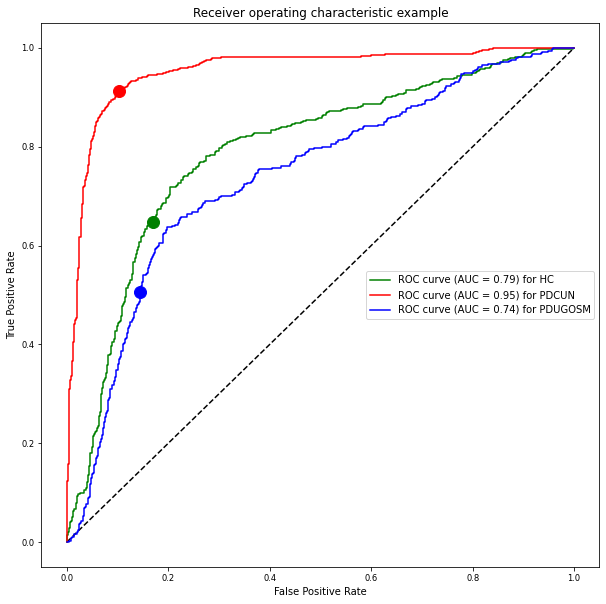

In [60]:
testlist = list(chain.from_iterable(zip(*testlabelsd)))
probabiltylist = list(chain.from_iterable(zip(*probabiltiesd)))
fpru = dict()
tpru = dict()
roc_aucu = dict()
for k in range(len(testlist)):

    n_classes=['HC','PDCUN', 'PDUGOSM']

    # structures
    fpr = dict()

    tpr = dict()

    roc_auc = dict()
    
    
    
    fpr1 = dict()

    tpr1 = dict()

    roc_auc1 = dict()
    

    colorrange = ['green','red','blue']
    colorrange2 = ['green','red','blue']
    for i in range(len(n_classes)):
        
        # dictionary fpr tpr and roc calcualted per class per model and then stored in a bigger dict
        # Dict of Dict
        fpr[i], tpr[i], _ = roc_curve(testlist[k],probabiltylist[k][:,i],pos_label=n_classes[i], drop_intermediate=True)
        roc_auc[i] = auc(fpr[i], tpr[i])
        fpru[k] = fpr
        tpru[k] = tpr
        roc_aucu[k] = roc_auc
        
for j in range(len(n_classes)):
        fpr1[j], tpr1[j], _ = roc_curve(testlabelsdsingle,probabiltysingle[:,j],pos_label=n_classes[j], drop_intermediate=True)
        roc_auc1[j] = auc(fpr1[j], tpr1[j])

    
    
    
figsize=(10, 10)
# roc for each class
fig, ax = plt.subplots(figsize=figsize)



ax.plot([0, 1], [0, 1], 'k--')
#ax.set_xlim([0.0, 1.0])
#ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example') 


#for k1 in range(len(testlist)):
#    for i1 in range(len(n_classes)):  
#        ax.plot(fpru[k1][i1], tpru[k1][i1], label='_nolegend_',color=colorrange[i1])

        #ax.plot(PDCUN_fpr[i], PDCUN_fpr[i],  marker="o", markersize="12")
#        ax.plot(plotdict_fpr[k1][i1], plotdict_tpr[k1][i1],  color=colorrange[i1])#,marker="o", markersize="12")
        
        
#plotdict_tpr1 = ADUGOSM_tpr1,ADUMCG_tpr1,PDCUN_tpr1,PDUGOSM_tpr1,PDUMCG_tpr1
#plotdict_fpr1 = ADUGOSM_fpr1,ADUMCG_fpr1,PDCUN_tpr1,PDUGOSM_fpr1,PDUMCG_fpr1

for i2 in range(len(n_classes)):
    ax.plot(fpr1[i2], tpr1[i2], label='ROC curve (AUC = %0.2f) for %s' % (roc_auc1[i2], n_classes[i2]),color=colorrange2[i2])
    ax.plot(plotdict_fpr1[i2], plotdict_tpr1[i2], color=colorrange2[i2],marker="o", markersize="12")

ax.legend(loc="right")   
ax.grid(False)
fig.savefig('roc6class.png')
#ax.grid(alpha=.4)
plt.show()

In [61]:
len(roc_aucu)

100

In [62]:
average_ruc = dict()
# check this once
for i in range(len(n_classes)):
    sum = 0
    for key in roc_aucu:
        sum += roc_aucu[key][i]
    average_ruc[i] = sum/len(roc_aucu)



In [63]:
roc_auc1

{0: 0.7898715041572184, 1: 0.9527663661888577, 2: 0.7386761133603239}

In [64]:
HCindices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

## ROC curve for one trained model for 6 class classification

In [65]:
# removing the z transform
def visualizeSinglemodeld(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,prototypes1):

    transformed_data = model.transform(data,True)
    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]



    transformed_model = model.transform(prototypes1, scale=True)


    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]

    fig, ax = plt.subplots(figsize=(15,15))
    fig.suptitle("Maindataset disease data with corresponding prototypes")
    
    colors = ['lightgreen','red','orange']
    colorsHC = ['lightblue','blue']
    # check the ordering from 4 class
    labelHC = ['HCUGOSM_early','HCCUN_late']
    labelss = ['HC','PDCUN_late','PDUGOSM_early']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        if(i == 0):
            for hc in range(len(HCindices1)):
            #print('label0')
                ax.scatter(
                    x_d[HCindices1[hc]],
                    y_d[HCindices1[hc]],
                    c=colorsHC[hc],
                    s=100,
                    alpha=0.7,
                    edgecolors="white",
                    label = labelHC[hc])
                    #label = model.classes_[model.prototypes_labels_[i]])
        else:
            ax.scatter(
            x_d[ii],
            y_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label = labelss[i]
            #label=model.classes_[model.prototypes_labels_[i]]
        )

    
        
    #for i, txt in enumerate(HCindices):
        #ax.annotate(txt,(x_d[i],y_d[i]))
        #plt.scatter(x_d[ii],y_d[ii])
    
    
    for hc,txt in enumerate(HCindices):
        ax.annotate(txt,(x_d[HCindices[hc]],y_d[HCindices[hc]]))
        
        
    for hc1,txt1 in enumerate(labelss):
        ax.annotate(txt1,(x_m[hc1],y_m[HCindices[hc1]]),fontsize=20)
    
    ax.scatter(x_m, y_m, c=colors, s=500, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.legend()
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('disease_correction_singelmodel.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

returning if
returning if
['HC' 'PDCUN' 'PDUGOSM']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 


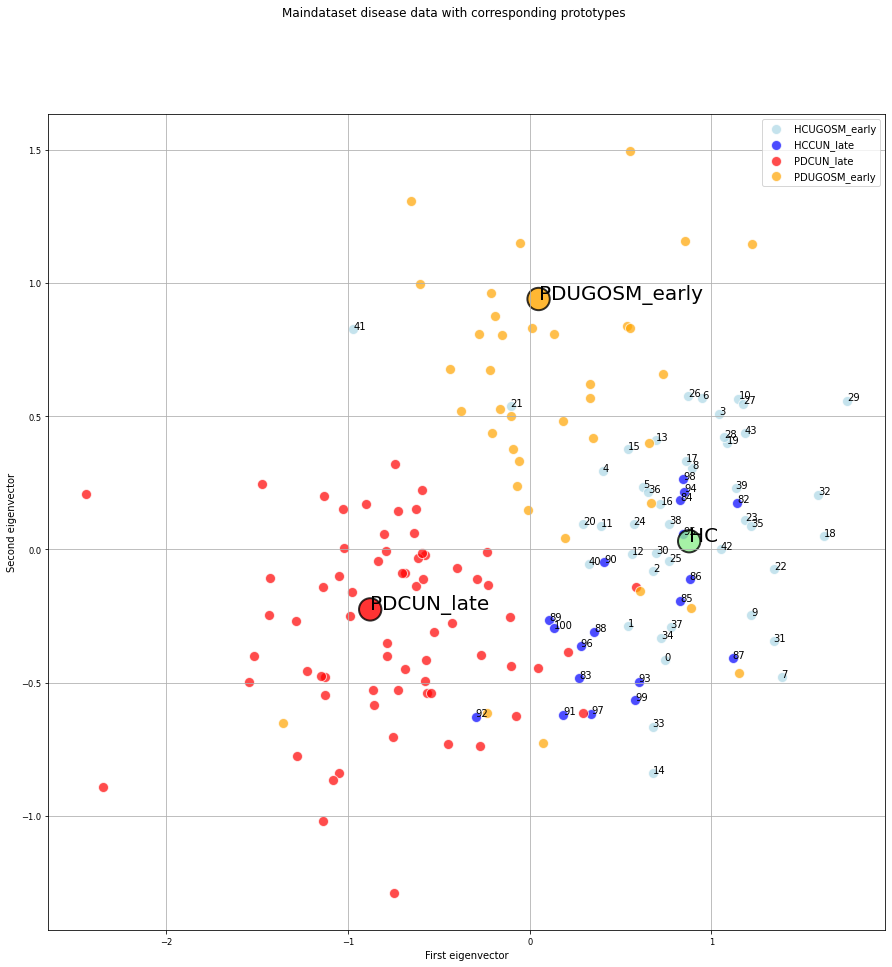

In [66]:
# model d is trained and fitted on oversampled data, BUT we plot the original datset. The whole point of oversampling was to increase the accuracy of the classifier
# training model d on oversampled data and plotting on non oversampled data makes a difference
# the scaled eigen vectors end up making a huge differendce for normal and overscaled dataset
visualizeSinglemodeld(modeld,scalarId,finaldatadisease,Finallabelsdisease,modeld.eigenvalues_,modeld.eigenvectors_,modeld.prototypes_)


returning if
returning if
['HC' 'PDCUN' 'PDUGOSM']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 


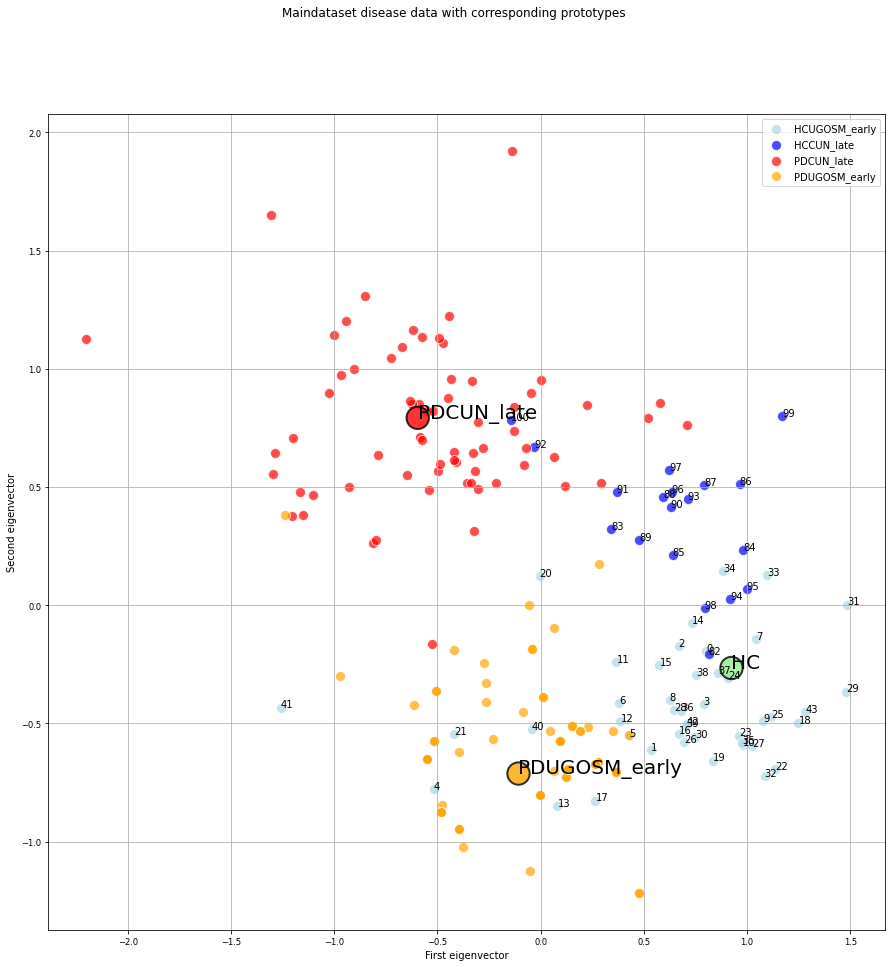

In [67]:
# model d is trained and fitted on oversampled data, BUT we plot the original datset. The whole point of oversampling was to increase the accuracy of the classifier
# training model d on oversampled data and plotting on non oversampled data makes a difference
# the scaled eigen vectors end up making a huge differendce for normal and overscaled dataset
visualizeSinglemodeld(modeld_oversampled,scalard__oversampled,finaldatadisease_oversampled,Finallabelsdisease_oversampled,modeld_oversampled.eigenvalues_,modeld_oversampled.eigenvectors_,modeld_oversampled.prototypes_)


## visualize models 6 class

In [70]:
# removing the z transform
def visualizeSinglemodelc(model,scalarI,data,labels,eigenvaluesaverage,eigenvectoraverage,prototypes1):
    #data = scalarI.inverse_transform(data)    
    transformed_data = model.transform(data,True)
    
    # all examples 1st and 2nd feature
    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]

    # Transform the model, i.e., the prototypes (scaled by square root of eigenvalues "scale = True")
    # prototype inverser transform
    #prototypes = scalarI.inverse_transform(prototypes1)

    transformed_model = model.transform(prototypes1, scale=True)

    #transformed_model = transform1(prototypes,eigenvaluesaverage,eigenvectoraverage,scale=True)

    x_m = transformed_model[:, 0]
    y_m = transformed_model[:, 1]

    fig, ax = plt.subplots(figsize=(15,15))
    fig.suptitle("Maindataset center data with corresponding prototypes")
    colors = ['pink','magenta']#,'red','lightgreen']
    for i, cls in enumerate(model.classes_):
        ii = cls == labels
        ax.scatter(
            x_d[ii],
            y_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model.classes_[model.prototypes_labels_[i]],
        )
    #for i, txt in enumerate(HC_UGOSM_CUN):
    #    ax.annotate(txt,(x_d[i],y_d[i]))
    ax.scatter(x_m, y_m, c=colors, s=500, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.legend()
    #plt.ylim([-1, 30])
    #plt.xlim([-30, 30])
    ax.grid(True)
    print(model.classes_)
    #fig.savefig('visualize_center.eps', format='eps')
    fig.savefig('center_correction_singelmodel.png')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

returning if
returning if
['CUN' 'UGOSM']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 


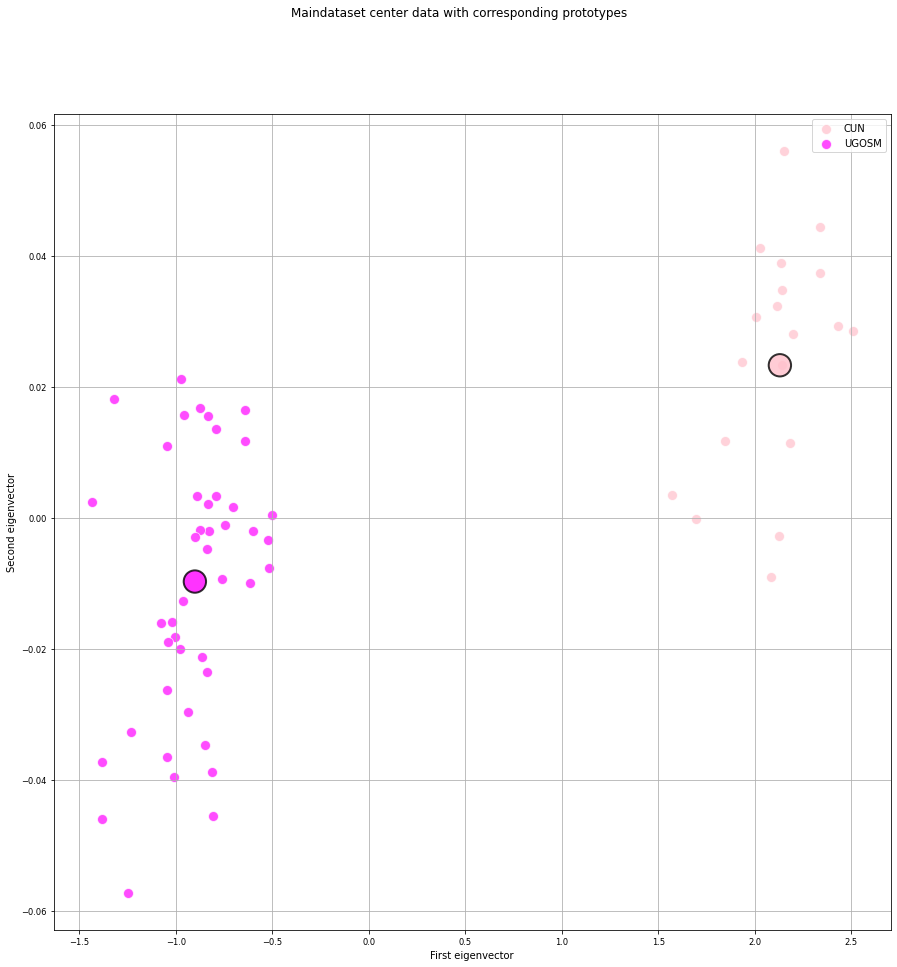

In [71]:
visualizeSinglemodelc(modelc,scalarIc,finaldatacenter1,finalcenterlabels1,modelc.eigenvalues_,modelc.eigenvectors_,modelc.prototypes_)


In [72]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
def ploteigenvalues(eigenvalues,eigenvectors,average_lambda,d):
    fig, ax = plt.subplots()
    fig.suptitle("Eigen values with correction "+d+ " main data")
    ax.bar(range(0, len(eigenvalues)), eigenvalues)
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('eigenvalues'+d+'.eps', format='eps')
    fig.savefig('eigenvalues'+d+'.png')
    #fig.savefig('eigenvalues+d+.svg", format ='svg', dpi=1200)


    # Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
    fig, ax = plt.subplots()
    fig.suptitle("First Eigenvector with correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[0, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Firsteigenvector'+d+'.eps', format='eps')
    fig.savefig('Firsteigenvector'+d+'.png')
    
    fig, ax = plt.subplots()
    fig.suptitle("Second Eigenvector with correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[1, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Secondeigenvector'+d+'.eps', format='eps')
    fig.savefig('Secondeigenvector'+d+'.png')
    fig, ax = plt.subplots()
    
    
    # The relevance matrix is available after fitting the model.
    relevance_matrix = average_lambda
    
    
    error = np.std(average_lambda_center,axis=0)
    fig.suptitle("Relevance Matrix Diagonal with correction " +d+ " main data")
    ax.bar(feature_names,np.diagonal(relevance_matrix),yerr=error)
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('relevancematrix'+d+'.eps', format='eps')
    fig.savefig('relevancematrix'+d+'.png')

In [ ]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
def ploteigenvalueswithout(eigenvalues,eigenvectors,average_lambda,d):
    fig, ax = plt.subplots()
    fig.suptitle("Eigen values without correction "+d+ " main data")
    ax.bar(range(0, len(eigenvalues)), eigenvalues)
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('eigenvalues'+d+'.eps', format='eps')
    fig.savefig('eigenvalues'+d+'.png')
    #fig.savefig('eigenvalues+d+.svg", format ='svg', dpi=1200)


    # Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
    fig, ax = plt.subplots()
    fig.suptitle("First Eigenvector without correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[0, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Firsteigenvector'+d+'.eps', format='eps')
    fig.savefig('Firsteigenvector'+d+'.png')
    
    fig, ax = plt.subplots()
    fig.suptitle("Second Eigenvector without correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[1, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Secondeigenvector'+d+'.eps', format='eps')
    fig.savefig('Secondeigenvector'+d+'.png')
    fig, ax = plt.subplots()
    
    
    # plot diagonal, std and mean per feature for all dimensions
    relevance_matrix = average_lambda
    #means = np.mean(average_lambda_center,axis=0)
    #error = np.std(average_lambda_center,axis=0)
    error = average_lambad_disease_permodel
    fig.suptitle("Relevance Matrix Diagonal without correction " +d+ " main data")
    ax.bar(feature_names,np.diagonal(relevance_matrix),yerr=error)
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('relevancematrix'+d+'.eps', format='eps')
    fig.savefig('relevancematrix'+d+'.png')
    

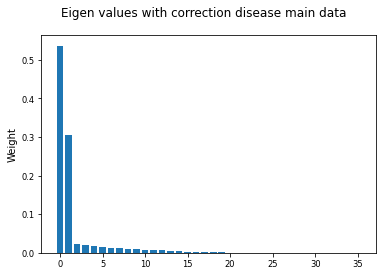

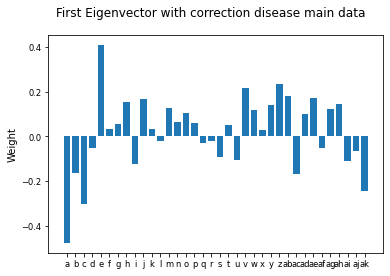

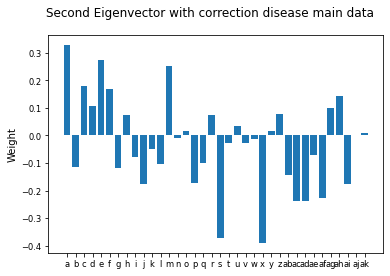

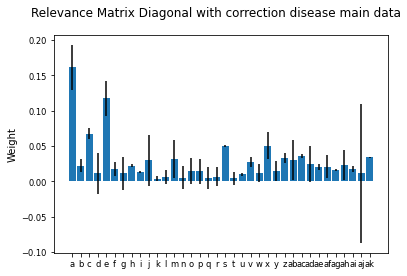

In [74]:
ploteigenvalues(modeld.eigenvalues_,modeld.eigenvectors_,modeld.lambda_,'disease')

In [ ]:
ploteigenvalues(modelc.eigenvalues_,modelc.eigenvectors_,modelc.lambda_,'center')